In [52]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
# Read data
df = pd.read_csv('data/cleaned_data.csv')

In [7]:
df["Cleaned Content"].isna().sum()

18

In [8]:
df = df[df["Cleaned Content"].notna()]
df["Cleaned Content"].isna().sum()

0

## Sentiment Classification

In [19]:
sia = SentimentIntensityAnalyzer()

def classify_sentiment(text):
    if not text.strip():  # Skip empty strings
        return None
    score = TextBlob(text).sentiment.polarity
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'
    

In [20]:
df["Sentiment"] = df["Cleaned Content"].apply(classify_sentiment)

C:\Users\somai\AppData\Local\Temp\ipykernel_1696\1223433636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Sentiment"] = df["Cleaned Content"].apply(classify_sentiment)


In [22]:
df["Sentiment"].value_counts()

Sentiment
Neutral     8114
Negative    4270
Positive    3213
Name: count, dtype: int64

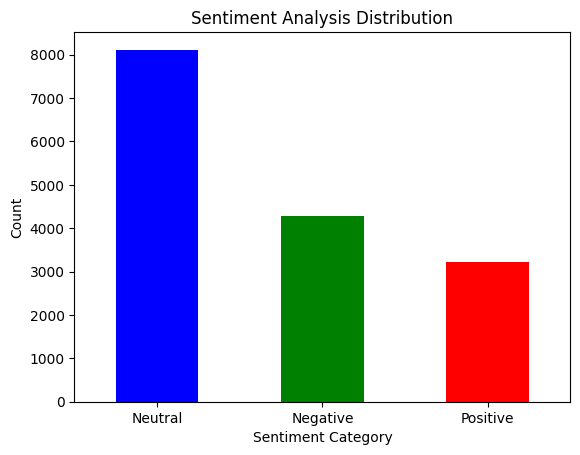

<Figure size 640x480 with 0 Axes>

In [89]:
df["Sentiment"].value_counts().plot(kind='bar', color = ["blue", "green", "red"])
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.title("Sentiment Analysis Distribution")
plt.xticks(rotation = 0)

plt.show()
plt.savefig("vis/Sentiment Analysis Distribution.png")

In [25]:
HIGH_RISK_TERMS = [
    "i dont want to be here", "end my life", "suicide", "self harm", "giving up",
    "no way out", "i cant do this anymore", "i hate myself", "i want to die",
    "life is pointless", "i cant go on", "i wish i was dead", "i feel hopeless",
    "i want to disappear", "i cant take it anymore", "i want it all to end", "death"
]

MODERATE_RISK_TERMS = [
    "feel lost", "struggling", "i need help", "overwhelmed", "anxiety attack",
    "cant cope", "feeling hopeless", "i feel alone", "i feel trapped",
    "i feel worthless", "i cant handle this", "i feel like a burden",
    "i feel empty inside", "i feel like a failure", "i feel so sad",
    "i feel like no one cares"
]

In [27]:
def classify_risk(text):
    text_lower = text.lower()
    if any(term in text_lower for term in MODERATE_RISK_TERMS):
        return "Moderate Risk"
    elif any(term in text_lower for term in HIGH_RISK_TERMS):
        return "High Risk"
    else:
        return "Low Risk"

In [28]:
df["Risk Level"] = df["Content"].apply(classify_risk)

C:\Users\somai\AppData\Local\Temp\ipykernel_1696\1784640094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Risk Level"] = df["Content"].apply(classify_risk)


In [32]:
df["Risk Level"].value_counts()

Risk Level
Low Risk         9295
Moderate Risk    3259
High Risk        3043
Name: count, dtype: int64

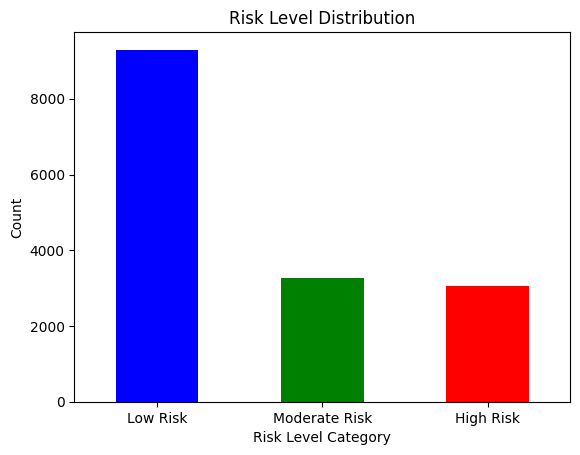

<Figure size 640x480 with 0 Axes>

In [88]:
df["Risk Level"].value_counts().plot(kind='bar', color = ["blue", "green", "red"])
plt.xlabel("Risk Level Category")
plt.ylabel("Count")
plt.title("Risk Level Distribution")
plt.xticks(rotation = 0)

plt.show()
plt.savefig("vis/risk_level_distribution.png")

## Word Embedding

In [37]:
vectorize = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorize.fit_transform(df["Cleaned Content"])

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
model = BertModel.from_pretrained("google-bert/bert-base-uncased")


In [38]:
def get_bert_embedding(text):
    tokens = tokenizer(text, padding = True, truncation = True, return_tensors = "pt")
    with torch.no_grad():
        output = model(**tokens)
    return output.last_hidden_state.mean(dim = 1).squeeze().numpy()

In [39]:
df["Bert Embedding"] = df["Cleaned Content"].apply(lambda x: get_bert_embedding(x) if x else None)

C:\Users\somai\AppData\Local\Temp\ipykernel_1696\3994763011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Bert Embedding"] = df["Cleaned Content"].apply(lambda x: get_bert_embedding(x) if x else None)


In [40]:
df

,Subreddit,Post ID,Timestamp,Content,likes,Comments,Content Type,Cleaned Content,Sentiment,Risk Level,Bert Embedding
0,mentalhealth,1gd9l9c,2024-10-27 12:13:33,Hello friends!\n\nIt's that time of the year a...,19,11,str,hello friend time year always intend rmentalhe...,Positive,High Risk,"[-0.08683058, 0.118400864, 0.6282184, -0.07012..."
1,mentalhealth,1e297nd,2024-07-13 12:25:58,Hey r/mentalhealth! We're looking to grow our ...,22,27,str,hey rmentalhealth look grow moderation team mo...,Positive,Low Risk,"[0.0032887922, 0.089250885, 0.5293215, -0.2988..."
2,mentalhealth,1jde2d0,2025-03-17 14:33:42,My bf(20M) and i(17F) have known eachother for...,85,85,str,bfm know eachother year together month long ag...,Neutral,Moderate Risk,"[-0.037823014, 0.21667117, 0.75306135, -0.0281..."
3,mentalhealth,1jd37mh,2025-03-17 03:09:36,The number of posts by people claiming to get ...,138,88,str,number post people claim get therapy chatgpt g...,Neutral,Moderate Risk,"[0.12454561, 0.20441417, 0.56812185, -0.030979..."
4,mentalhealth,1jd4smm,2025-03-17 04:43:27,"My brother attempted to hang himself tonight, ...",65,17,str,brother attempt hang tonight call fail thing h...,Neutral,Low Risk,"[0.0513198, 0.098947324, 0.53935283, -0.256467..."
...,...,...,...,...,...,...,...,...,...,...,...
15610,SuicideWatch,1jd3j9x,2025-03-17 03:27:36,I don't think I've ever felt so close to endin...,2,1,str,think ever feel close ending last year bad eve...,Negative,Moderate Risk,"[0.16451655, -0.0022463868, 0.61836493, -0.108..."
15611,SuicideWatch,1jd6tn4,2025-03-17 07:06:40,*I want to commit suicide but I don't like the...,1,0,str,want commit suicide like idea shoot head jumpi...,Negative,Moderate Risk,"[0.24172686, -0.11162655, 0.6021544, -0.080056..."
15612,SuicideWatch,1jcyq4m,2025-03-16 23:21:33,"Growing up, people bullied me a lot. Some of i...",4,2,str,grow people bully lot deserve graduate high sc...,Neutral,Moderate Risk,"[-0.14518625, 0.015065777, 0.84108937, -0.1884..."
15613,SuicideWatch,1jd0lig,2025-03-17 00:51:59,\nIt’s not like I’m suicidal for attention or ...,3,0,str,like suicidal attention maybe like class even ...,Negative,High Risk,"[-0.04664371, -0.05316484, 0.98232234, -0.2226..."


In [ ]:

# Convert embeddings column to NumPy array
embeddings = np.vstack(df["Bert Embedding"].values)

# -------- K-Means Clustering --------
kmeans = KMeans(n_clusters=3, random_state=42)
df["KMeans Cluster"] = kmeans.fit_predict(embeddings)

# -------- DBSCAN Clustering --------
dbscan = DBSCAN(eps=0.5, min_samples=2)  
df["DBSCAN Cluster"] = dbscan.fit_predict(embeddings)

# -------- PCA for Visualization --------
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)



C:\Users\somai\AppData\Local\Temp\ipykernel_1696\245048818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["KMeans Cluster"] = kmeans.fit_predict(embeddings)
C:\Users\somai\AppData\Local\Temp\ipykernel_1696\245048818.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DBSCAN Cluster"] = dbscan.fit_predict(embeddings)


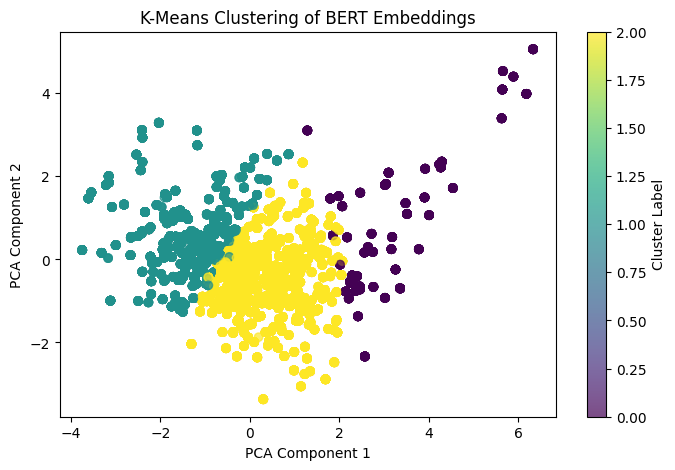

<Figure size 640x480 with 0 Axes>

In [87]:

plt.figure(figsize=(8, 5))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df["KMeans Cluster"], cmap="viridis", alpha=0.7)
plt.colorbar(label="Cluster Label")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering of BERT Embeddings")
plt.show()
plt.savefig("vis/K-Means Clustering of BERT Embeddings.png")

In [49]:
df["vector_representation"] = df["Bert Embedding"].apply(lambda x: np.mean(x, axis=0))


C:\Users\somai\AppData\Local\Temp\ipykernel_1696\3043850360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vector_representation"] = df["Bert Embedding"].apply(lambda x: np.mean(x, axis=0))


## Logistic Regression

In [ ]:
# Prepare feature matrix (X) and labels (y)
X = np.vstack(df["vector_representation"].values)
y = df["Risk Level"]  # Assuming labels are "Positive", "Negative", "Neutral"

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Accuracy: 0.60


In [ ]:
# Train a classifier
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


               precision    recall  f1-score   support

    High Risk       0.00      0.00      0.00       587
     Low Risk       0.60      1.00      0.75      1883
Moderate Risk       0.00      0.00      0.00       650

     accuracy                           0.60      3120
    macro avg       0.20      0.33      0.25      3120
 weighted avg       0.36      0.60      0.45      3120



c:\Users\somai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\somai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\somai\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

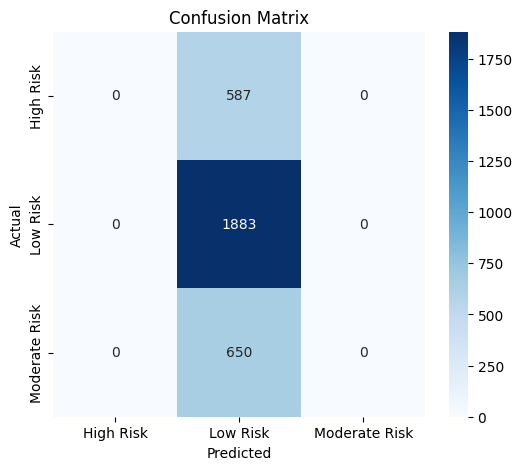

In [55]:

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["High Risk", "Low Risk", "Moderate Risk"], 
            yticklabels=["High Risk", "Low Risk", "Moderate Risk"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Improve Model

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

# Ensure y_train is a NumPy array
y_train = np.array(y_train)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}




In [57]:
# Initialize the model with class weights
model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=5, 
    class_weight=class_weight_dict, 
    random_state=42
)

In [64]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.85


In [62]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

    High Risk       0.91      0.84      0.87       587
     Low Risk       0.95      0.82      0.88      1883
Moderate Risk       0.63      0.92      0.75       650

     accuracy                           0.85      3120
    macro avg       0.83      0.86      0.84      3120
 weighted avg       0.88      0.85      0.85      3120



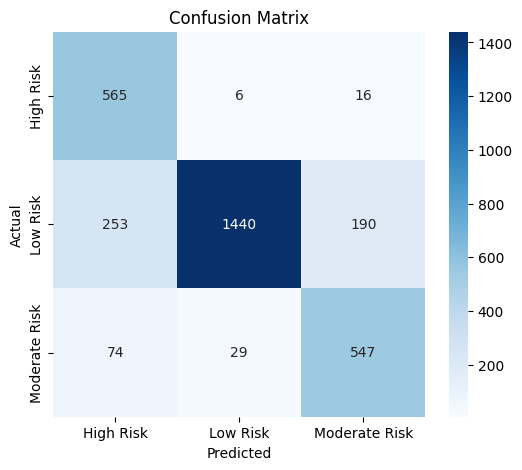

<Figure size 640x480 with 0 Axes>

In [86]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plt.savefig("vis/vecRandomforest_confusion_matrix.png")

In [65]:
df.to_csv("data/processed_data.csv", index=False)

## Try model with cls embedding

In [70]:
df["cls_embedding"] = df["Bert Embedding"].apply(lambda x: x[0])  # First token is [CLS]

C:\Users\somai\AppData\Local\Temp\ipykernel_1696\3293155873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cls_embedding"] = df["Bert Embedding"].apply(lambda x: x[0])  # First token is [CLS]


In [72]:
# Prepare feature matrix (X) and labels (y)
X = np.vstack(df["cls_embedding"].values)
y = df["Risk Level"]  # Assuming labels are "Positive", "Negative", "Neutral"

# Split data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y, test_size=0.2, random_state=42)



In [75]:
# Ensure y_train is a NumPy array
y_train_cls = np.array(y_train_cls)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_cls), y=y_train_cls)

# Convert to dictionary
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train_cls), class_weights)}




In [76]:
# Initialize the model with class weights
model = RandomForestClassifier(
    n_estimators=50, 
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=5, 
    class_weight=class_weight_dict, 
    random_state=42
)

In [82]:
model.fit(X_train_cls, y_train_cls)
y_pred_cls = model.predict(X_test_cls)

accuracy = model.score(X_test_cls, y_test_cls)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


In [83]:
print("\n🎯 Classification Report:\n", classification_report(y_test_cls, y_pred_cls))



🎯 Classification Report:
                precision    recall  f1-score   support

    High Risk       0.63      0.96      0.76       587
     Low Risk       0.98      0.76      0.86      1883
Moderate Risk       0.73      0.84      0.78       650

     accuracy                           0.82      3120
    macro avg       0.78      0.86      0.80      3120
 weighted avg       0.86      0.82      0.82      3120



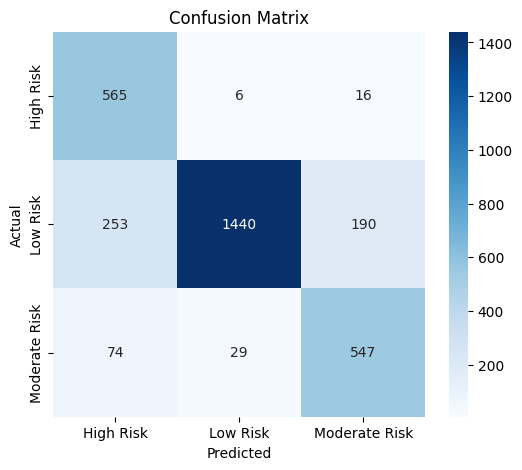

<Figure size 640x480 with 0 Axes>

In [85]:
# 🚀 Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
plt.savefig("vis/clsRandomforest_confusion_matrix.png")

In [90]:
df.to_csv("data/processed_data.csv", index=False)